<a href="https://colab.research.google.com/github/Ravindu56/spleen_prediction_model/blob/dev/Spleen_prediction_model_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FINAL OPTIMIZED LINEAR REGRESSION MODELS

##### STEP 0: GPU SETUP

In [ ]:
print("\n[SETTING UP ENVIRONMENT]")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import joblib
import os
warnings.filterwarnings('ignore')

# Standard sklearn models (CPU-optimized)
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error,
                             mean_absolute_percentage_error)

print("✓ Libraries imported")

print("\n[CPU OPTIMIZATION]")

# Get CPU cores
n_cpus = os.cpu_count()
print(f"Available CPU cores: {n_cpus}")

# Enable parallel processing in sklearn
N_JOBS = -1  # Use all available cores

# Configure threading for numerical libraries
os.environ['OMP_NUM_THREADS'] = str(n_cpus)
os.environ['MKL_NUM_THREADS'] = str(n_cpus)
os.environ['OPENBLAS_NUM_THREADS'] = str(n_cpus)

print(f"✓ Multi-threading enabled: {n_cpus} cores")
print("✓ GridSearchCV will parallelize across all cores")


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

print("✓ Random seed set:", RANDOM_STATE)



[SETTING UP ENVIRONMENT]
✓ Libraries imported

[CPU OPTIMIZATION]
Available CPU cores: 2
✓ Multi-threading enabled: 2 cores
✓ GridSearchCV will parallelize across all cores
✓ Random seed set: 42


##### STEP 2: LOAD & PREPARE DATA

In [ ]:
from google.colab import files
print("\nUpload Original.xlsx...")
uploaded = files.upload()

df = pd.read_excel(list(uploaded.keys())[0])
print(f"✓ Dataset: {df.shape}")

# Clean outliers
outlier_mask_length = df['Length (cm)'] > 20
if outlier_mask_length.sum() > 0:
    df.loc[outlier_mask_length, 'Length (cm)'] /= 10
    print(f"✓ Fixed {outlier_mask_length.sum()} Length outlier(s)")

outlier_mask_width = df['Width (cm)'] > 15
if outlier_mask_width.sum() > 0:
    df.loc[outlier_mask_width, 'Width (cm)'] /= 10
    print(f"✓ Fixed {outlier_mask_width.sum()} Width outlier(s)")

# Feature engineering
df['BSA'] = np.sqrt((df['Height'] * df['weight']) / 3600)
df['age_group'] = pd.cut(df['Age'], bins=[0, 35, 50, 65, 100],
                          labels=['young', 'middle', 'senior', 'elderly'])

# Best feature set from analysis
features = ['Age', 'weight', 'Height', 'BSA']
targets = ['Length (cm)', 'Width (cm)', 'volume (cm3)']

print(f"✓ Features: {features}")
print(f"✓ Targets: {targets}")

# Train-test split
X = df[features].copy()
y = df[targets].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE,
    stratify=df['age_group']
)

print(f"✓ Train: {len(X_train)}, Test: {len(X_test)}")


Upload Original.xlsx...


Saving Original.xlsx to Original.xlsx
✓ Dataset: (223, 7)
✓ Fixed 3 Length outlier(s)
✓ Features: ['Age', 'weight', 'Height', 'BSA']
✓ Targets: ['Length (cm)', 'Width (cm)', 'volume (cm3)']
✓ Train: 178, Test: 45


##### STEP 3: MODEL-SPECIFIC OPTIMIZATION

In [ ]:
final_models = {}
optimization_results = {}

# LENGTH (cm): OLS + Ridge Comparison (OLS performed best)
print("\n" + "─"*80)
print("LENGTH (cm) - OLS vs Ridge Fine-Tuning")
print("─"*80)

# Scaler for Length
scaler_length = StandardScaler()
X_train_scaled_length = scaler_length.fit_transform(X_train)
X_test_scaled_length = scaler_length.transform(X_test)

target = 'Length (cm)'

# Model 1: OLS (baseline - performed best in comparison)
start_time = time.time()
ols_length = LinearRegression()
ols_length.fit(X_train_scaled_length, y_train[target])

# Evaluate OLS
train_pred_ols = ols_length.predict(X_train_scaled_length)
test_pred_ols = ols_length.predict(X_test_scaled_length)

ols_train_r2 = r2_score(y_train[target], train_pred_ols)
ols_test_r2 = r2_score(y_test[target], test_pred_ols)
ols_test_mae = mean_absolute_error(y_test[target], test_pred_ols)
ols_test_rmse = np.sqrt(mean_squared_error(y_test[target], test_pred_ols))
ols_test_mape = mean_absolute_percentage_error(y_test[target], test_pred_ols)
ols_cv_scores = cross_val_score(ols_length, X_train_scaled_length, y_train[target],
                                 cv=10, scoring='r2')

print(f"\nOLS Results:")
print(f"  Train R²: {ols_train_r2:.4f}")
print(f"  Test R²: {ols_test_r2:.4f}")
print(f"  Test MAE: {ols_test_mae:.4f} cm")
print(f"  Test RMSE: {ols_test_rmse:.4f} cm")
print(f"  Test MAPE: {ols_test_mape*100:.2f}%")
print(f"  CV R² (10-fold): {ols_cv_scores.mean():.4f} ± {ols_cv_scores.std():.4f}")

# Model 2: Ridge (optimize alpha for comparison)
alpha_range_length = np.linspace(1, 200, 100)

ridge_length = Ridge()
grid_length = GridSearchCV(ridge_length, {'alpha': alpha_range_length},
                           cv=10, scoring='r2', n_jobs=-1)
grid_length.fit(X_train_scaled_length, y_train[target])

best_ridge_length = grid_length.best_estimator_
best_alpha_length = grid_length.best_params_['alpha']
ridge_cv_r2 = grid_length.best_score_

test_pred_ridge = best_ridge_length.predict(X_test_scaled_length)
ridge_test_r2 = r2_score(y_test[target], test_pred_ridge)
ridge_test_mae = mean_absolute_error(y_test[target], test_pred_ridge)
ridge_test_rmse = np.sqrt(mean_squared_error(y_test[target], test_pred_ridge))
ridge_test_mape = mean_absolute_percentage_error(y_test[target], test_pred_ridge)

elapsed = time.time() - start_time

print(f"\nRidge Results:")
print(f"  Best alpha: {best_alpha_length:.2f}")
print(f"  CV R² (10-fold): {ridge_cv_r2:.4f}")
print(f"  Test R²: {ridge_test_r2:.4f}")
print(f"  Test MAE: {ridge_test_mae:.4f} cm")
print(f"  Test RMSE: {ridge_test_rmse:.4f} cm")
print(f"  Test MAPE: {ridge_test_mape*100:.2f}%")
print(f"  Time: {elapsed:.2f}s")

# Select best model for Length
if ols_test_r2 >= ridge_test_r2:
    final_model_length = ols_length
    length_model_name = 'OLS'
    length_results = {
        'model_name': 'OLS',
        'test_r2': ols_test_r2,
        'test_mae': ols_test_mae,
        'test_rmse': ols_test_rmse,
        'test_mape': ols_test_mape,
        'cv_r2_mean': ols_cv_scores.mean(),
        'cv_r2_std': ols_cv_scores.std(),
        'train_r2': ols_train_r2
    }
else:
    final_model_length = best_ridge_length
    length_model_name = f'Ridge (α={best_alpha_length:.2f})'
    length_results = {
        'model_name': f'Ridge (α={best_alpha_length:.2f})',
        'alpha': best_alpha_length,
        'test_r2': ridge_test_r2,
        'test_mae': ridge_test_mae,
        'test_rmse': ridge_test_rmse,
        'test_mape': ridge_test_mape,
        'cv_r2_mean': ridge_cv_r2,
        'train_r2': r2_score(y_train[target], best_ridge_length.predict(X_train_scaled_length))
    }

print(f"\n✓ SELECTED FOR LENGTH: {length_model_name}")

final_models[target] = {
    'model': final_model_length,
    'scaler': scaler_length,
    'model_name': length_model_name
}

optimization_results[target] = length_results

# WIDTH (cm): HuberRegressor (performed best in comparison)

print("\n" + "─"*80)
print("WIDTH (cm) - HuberRegressor Optimization")
print("─"*80)

scaler_width = StandardScaler()
X_train_scaled_width = scaler_width.fit_transform(X_train)
X_test_scaled_width = scaler_width.transform(X_test)

target = 'Width (cm)'

# Optimize HuberRegressor hyperparameters
param_grid_width = {
    'epsilon': [1.1, 1.35, 1.5, 1.75, 2.0],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
}

start_time = time.time()

huber_width = HuberRegressor(max_iter=1000)
grid_width = GridSearchCV(huber_width, param_grid_width,
                          cv=10, scoring='r2', n_jobs=-1)
grid_width.fit(X_train_scaled_width, y_train[target])

best_huber_width = grid_width.best_estimator_
best_params_width = grid_width.best_params_
width_cv_r2 = grid_width.best_score_

# Evaluate
train_pred_width = best_huber_width.predict(X_train_scaled_width)
test_pred_width = best_huber_width.predict(X_test_scaled_width)

width_train_r2 = r2_score(y_train[target], train_pred_width)
width_test_r2 = r2_score(y_test[target], test_pred_width)
width_test_mae = mean_absolute_error(y_test[target], test_pred_width)
width_test_rmse = np.sqrt(mean_squared_error(y_test[target], test_pred_width))
width_test_mape = mean_absolute_percentage_error(y_test[target], test_pred_width)

elapsed = time.time() - start_time

print(f"\nHuberRegressor Results:")
print(f"  Best epsilon: {best_params_width['epsilon']:.2f}")
print(f"  Best alpha: {best_params_width['alpha']:.4f}")
print(f"  Train R²: {width_train_r2:.4f}")
print(f"  Test R²: {width_test_r2:.4f}")
print(f"  Test MAE: {width_test_mae:.4f} cm")
print(f"  Test RMSE: {width_test_rmse:.4f} cm")
print(f"  Test MAPE: {width_test_mape*100:.2f}%")
print(f"  CV R² (10-fold): {width_cv_r2:.4f}")
print(f"  Time: {elapsed:.2f}s")

print(f"\n✓ SELECTED FOR WIDTH: HuberRegressor (ε={best_params_width['epsilon']:.2f}, α={best_params_width['alpha']:.4f})")

final_models[target] = {
    'model': best_huber_width,
    'scaler': scaler_width,
    'model_name': f"HuberRegressor (ε={best_params_width['epsilon']:.2f}, α={best_params_width['alpha']:.4f})"
}

optimization_results[target] = {
    'model_name': f"HuberRegressor (ε={best_params_width['epsilon']:.2f}, α={best_params_width['alpha']:.4f})",
    'epsilon': best_params_width['epsilon'],
    'alpha': best_params_width['alpha'],
    'test_r2': width_test_r2,
    'test_mae': width_test_mae,
    'test_rmse': width_test_rmse,
    'test_mape': width_test_mape,
    'cv_r2_mean': width_cv_r2,
    'train_r2': width_train_r2
}


# VOLUME (cm³): HuberRegressor (performed best in comparison)
print("\n" + "─"*80)
print("VOLUME (cm³) - HuberRegressor Optimization")
print("─"*80)

# Try RobustScaler (performed slightly better for Volume)
scaler_volume = RobustScaler()
X_train_scaled_volume = scaler_volume.fit_transform(X_train)
X_test_scaled_volume = scaler_volume.transform(X_test)

target = 'volume (cm3)'

# Optimize HuberRegressor for Volume
param_grid_volume = {
    'epsilon': [1.1, 1.35, 1.5, 1.75, 2.0, 2.5],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 50.0]
}

start_time = time.time()

huber_volume = HuberRegressor(max_iter=1000)
grid_volume = GridSearchCV(huber_volume, param_grid_volume,
                           cv=10, scoring='r2', n_jobs=-1)
grid_volume.fit(X_train_scaled_volume, y_train[target])

best_huber_volume = grid_volume.best_estimator_
best_params_volume = grid_volume.best_params_
volume_cv_r2 = grid_volume.best_score_

# Evaluate
train_pred_volume = best_huber_volume.predict(X_train_scaled_volume)
test_pred_volume = best_huber_volume.predict(X_test_scaled_volume)

volume_train_r2 = r2_score(y_train[target], train_pred_volume)
volume_test_r2 = r2_score(y_test[target], test_pred_volume)
volume_test_mae = mean_absolute_error(y_test[target], test_pred_volume)
volume_test_rmse = np.sqrt(mean_squared_error(y_test[target], test_pred_volume))
volume_test_mape = mean_absolute_percentage_error(y_test[target], test_pred_volume)

elapsed = time.time() - start_time

print(f"\nHuberRegressor Results:")
print(f"  Best epsilon: {best_params_volume['epsilon']:.2f}")
print(f"  Best alpha: {best_params_volume['alpha']:.4f}")
print(f"  Train R²: {volume_train_r2:.4f}")
print(f"  Test R²: {volume_test_r2:.4f}")
print(f"  Test MAE: {volume_test_mae:.4f} cm³")
print(f"  Test RMSE: {volume_test_rmse:.4f} cm³")
print(f"  Test MAPE: {volume_test_mape*100:.2f}%")
print(f"  CV R² (10-fold): {volume_cv_r2:.4f}")
print(f"  Scaler: RobustScaler")
print(f"  Time: {elapsed:.2f}s")

print(f"\n✓ SELECTED FOR VOLUME: HuberRegressor (ε={best_params_volume['epsilon']:.2f}, α={best_params_volume['alpha']:.4f})")

final_models[target] = {
    'model': best_huber_volume,
    'scaler': scaler_volume,
    'model_name': f"HuberRegressor (ε={best_params_volume['epsilon']:.2f}, α={best_params_volume['alpha']:.4f})"
}

optimization_results[target] = {
    'model_name': f"HuberRegressor (ε={best_params_volume['epsilon']:.2f}, α={best_params_volume['alpha']:.4f})",
    'epsilon': best_params_volume['epsilon'],
    'alpha': best_params_volume['alpha'],
    'test_r2': volume_test_r2,
    'test_mae': volume_test_mae,
    'test_rmse': volume_test_rmse,
    'test_mape': volume_test_mape,
    'cv_r2_mean': volume_cv_r2,
    'train_r2': volume_train_r2
}



────────────────────────────────────────────────────────────────────────────────
LENGTH (cm) - OLS vs Ridge Fine-Tuning
────────────────────────────────────────────────────────────────────────────────

OLS Results:
  Train R²: 0.1914
  Test R²: 0.2515
  Test MAE: 0.8977 cm
  Test RMSE: 1.1018 cm
  Test MAPE: 11.10%
  CV R² (10-fold): 0.0800 ± 0.2513

Ridge Results:
  Best alpha: 51.25
  CV R² (10-fold): 0.1058
  Test R²: 0.2255
  Test MAE: 0.9214 cm
  Test RMSE: 1.1207 cm
  Test MAPE: 11.40%
  Time: 3.90s

✓ SELECTED FOR LENGTH: OLS

────────────────────────────────────────────────────────────────────────────────
WIDTH (cm) - HuberRegressor Optimization
────────────────────────────────────────────────────────────────────────────────

HuberRegressor Results:
  Best epsilon: 1.50
  Best alpha: 10.0000
  Train R²: 0.0805
  Test R²: 0.0535
  Test MAE: 0.7954 cm
  Test RMSE: 1.0418 cm
  Test MAPE: 19.88%
  CV R² (10-fold): -0.0031
  Time: 7.52s

✓ SELECTED FOR WIDTH: HuberRegressor (ε=1.50

##### STEP 4: FINAL RESULTS SUMMARY

In [ ]:
summary_df = pd.DataFrame({
    'Target': ['Length (cm)', 'Width (cm)', 'Volume (cm³)'],
    'Model': [
        final_models['Length (cm)']['model_name'],
        final_models['Width (cm)']['model_name'],
        final_models['volume (cm3)']['model_name']
    ],
    'Test R²': [
        optimization_results['Length (cm)']['test_r2'],
        optimization_results['Width (cm)']['test_r2'],
        optimization_results['volume (cm3)']['test_r2']
    ],
    'CV R² (10-fold)': [
        optimization_results['Length (cm)']['cv_r2_mean'],
        optimization_results['Width (cm)']['cv_r2_mean'],
        optimization_results['volume (cm3)']['cv_r2_mean']
    ],
    'Test MAE': [
        optimization_results['Length (cm)']['test_mae'],
        optimization_results['Width (cm)']['test_mae'],
        optimization_results['volume (cm3)']['test_mae']
    ],
    'Test RMSE': [
        optimization_results['Length (cm)']['test_rmse'],
        optimization_results['Width (cm)']['test_rmse'],
        optimization_results['volume (cm3)']['test_rmse']
    ],
    'Test MAPE (%)': [
        optimization_results['Length (cm)']['test_mape'] * 100,
        optimization_results['Width (cm)']['test_mape'] * 100,
        optimization_results['volume (cm3)']['test_mape'] * 100
    ]
})

print("\n[FINAL OPTIMIZED MODELS]")
print(summary_df.to_string(index=False))


[FINAL OPTIMIZED MODELS]
      Target                              Model  Test R²  CV R² (10-fold)  Test MAE  Test RMSE  Test MAPE (%)
 Length (cm)                                OLS 0.251468         0.079978  0.897662   1.101760      11.102973
  Width (cm) HuberRegressor (ε=1.50, α=10.0000) 0.053527        -0.003069  0.795379   1.041777      19.884430
Volume (cm³)  HuberRegressor (ε=1.75, α=1.0000) 0.147615         0.031502 29.361120  37.709752      27.422998


##### STEP 5: VISUALIZATION

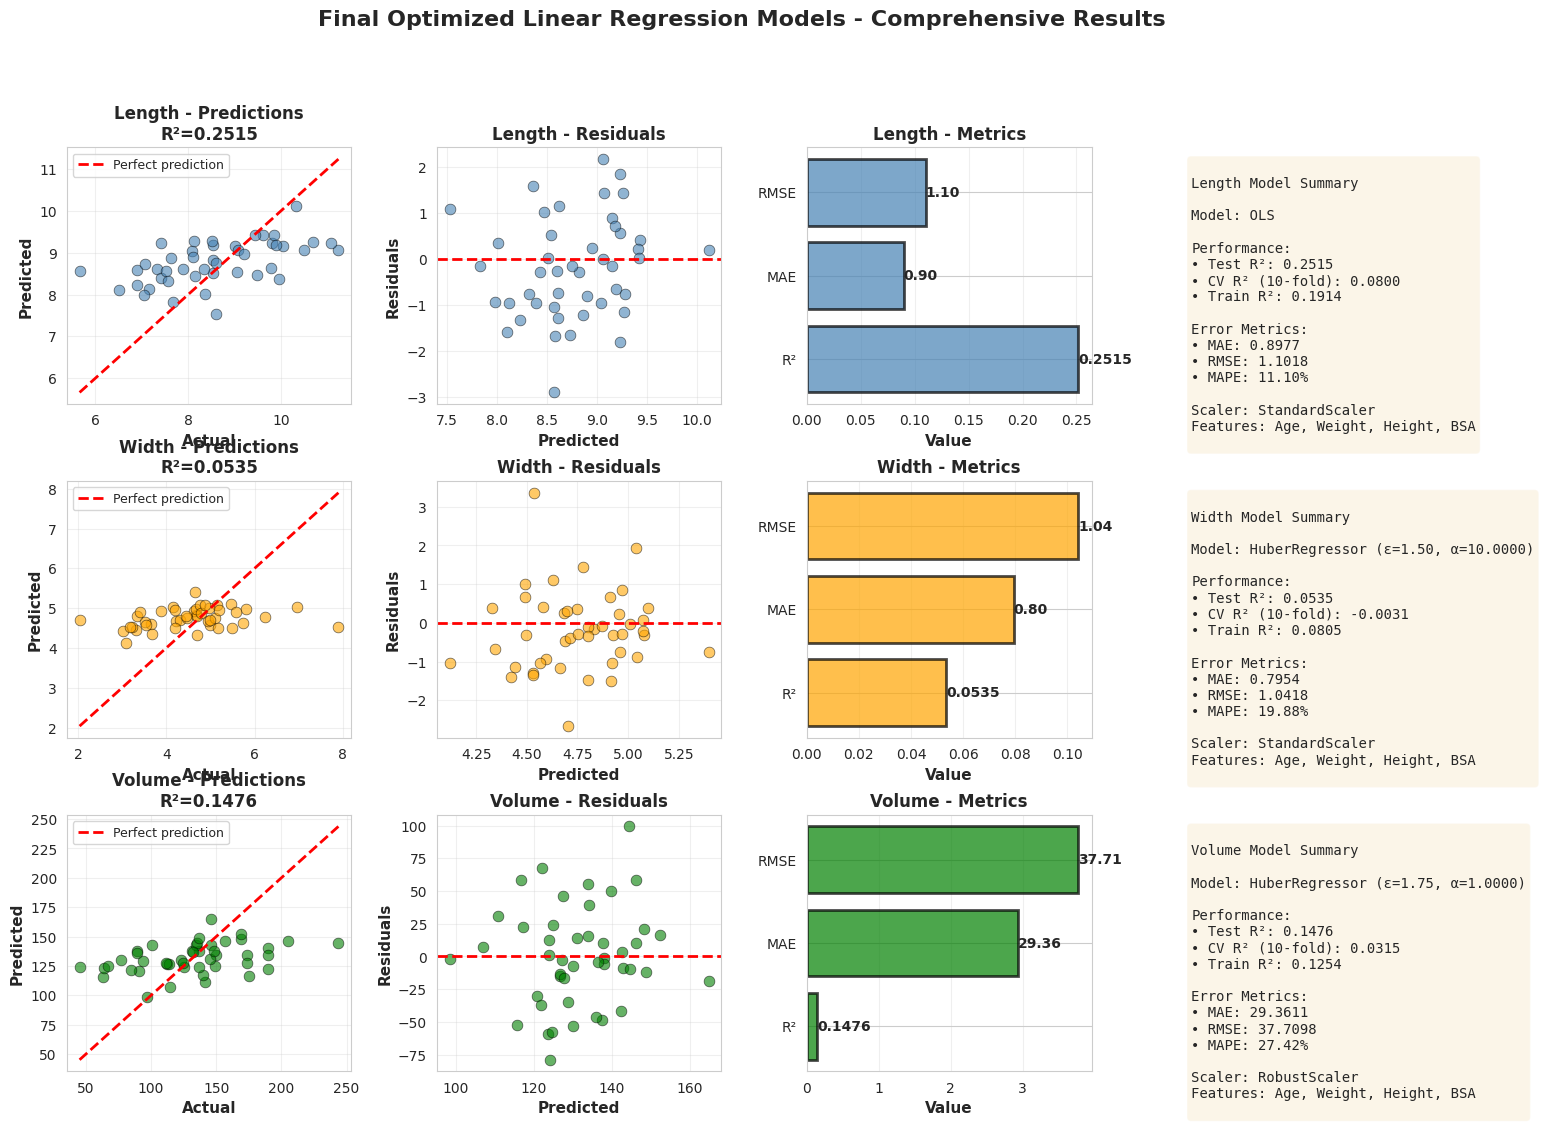

✓ Visualization saved: final_optimized_models.png


In [ ]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

targets_list = ['Length (cm)', 'Width (cm)', 'volume (cm3)']
target_names = ['Length', 'Width', 'Volume']
colors = ['steelblue', 'orange', 'green']

for idx, (target, target_name, color) in enumerate(zip(targets_list, target_names, colors)):

    # Get model and scaler
    model = final_models[target]['model']
    scaler = final_models[target]['scaler']

    # Get scaled data
    if target == 'Length (cm)':
        X_train_scaled = X_train_scaled_length
        X_test_scaled = X_test_scaled_length
    elif target == 'Width (cm)':
        X_train_scaled = X_train_scaled_width
        X_test_scaled = X_test_scaled_width
    else:
        X_train_scaled = X_train_scaled_volume
        X_test_scaled = X_test_scaled_volume

    # Predictions
    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)

    # Residuals
    test_residuals = y_test[target] - test_pred

    # Plot 1: Predicted vs Actual (Test Set)
    ax = fig.add_subplot(gs[idx, 0])
    ax.scatter(y_test[target], test_pred, alpha=0.6, s=60,
               color=color, edgecolors='black', linewidth=0.5)
    min_val = min(y_test[target].min(), test_pred.min())
    max_val = max(y_test[target].max(), test_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2,
            label='Perfect prediction')
    ax.set_xlabel('Actual', fontweight='bold', fontsize=11)
    ax.set_ylabel('Predicted', fontweight='bold', fontsize=11)
    ax.set_title(f'{target_name} - Predictions\nR²={optimization_results[target]["test_r2"]:.4f}',
                 fontweight='bold', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Plot 2: Residual Plot
    ax = fig.add_subplot(gs[idx, 1])
    ax.scatter(test_pred, test_residuals, alpha=0.6, s=60,
               color=color, edgecolors='black', linewidth=0.5)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax.set_xlabel('Predicted', fontweight='bold', fontsize=11)
    ax.set_ylabel('Residuals', fontweight='bold', fontsize=11)
    ax.set_title(f'{target_name} - Residuals', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Plot 3: Performance Metrics
    ax = fig.add_subplot(gs[idx, 2])
    metrics = ['R²', 'MAE', 'RMSE']
    values = [
        optimization_results[target]['test_r2'],
        optimization_results[target]['test_mae'] / 10,  # Scale for visualization
        optimization_results[target]['test_rmse'] / 10
    ]
    bars = ax.barh(metrics, values, color=color, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_xlabel('Value', fontweight='bold', fontsize=11)
    ax.set_title(f'{target_name} - Metrics', fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')
    for i, (bar, val) in enumerate(zip(bars, values)):
        if metrics[i] == 'R²':
            label = f'{optimization_results[target]["test_r2"]:.4f}'
        elif metrics[i] == 'MAE':
            label = f'{optimization_results[target]["test_mae"]:.2f}'
        else:
            label = f'{optimization_results[target]["test_rmse"]:.2f}'
        ax.text(val, bar.get_y() + bar.get_height()/2, label,
                va='center', ha='left', fontweight='bold', fontsize=10)

    # Plot 4: Model Info
    ax = fig.add_subplot(gs[idx, 3])
    ax.axis('off')
    info_text = f"""
{target_name} Model Summary

Model: {final_models[target]['model_name']}

Performance:
• Test R²: {optimization_results[target]['test_r2']:.4f}
• CV R² (10-fold): {optimization_results[target]['cv_r2_mean']:.4f}
• Train R²: {optimization_results[target]['train_r2']:.4f}

Error Metrics:
• MAE: {optimization_results[target]['test_mae']:.4f}
• RMSE: {optimization_results[target]['test_rmse']:.4f}
• MAPE: {optimization_results[target]['test_mape']*100:.2f}%

Scaler: {scaler.__class__.__name__}
Features: Age, Weight, Height, BSA
"""
    ax.text(0.05, 0.95, info_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('Final Optimized Linear Regression Models - Comprehensive Results',
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('final_optimized_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: final_optimized_models.png")


:#### STEP 6: MODEL COMPARISON WITH INITIAL RESULTS


In [ ]:
comparison_data = {
    'Length (cm)': {
        'Initial OLS': {'R²': 0.2515, 'MAE': 0.8977},
        'Initial Ridge': {'R²': 0.2506, 'MAE': 0.8983},
        f'Final {length_model_name}': {
            'R²': optimization_results['Length (cm)']['test_r2'],
            'MAE': optimization_results['Length (cm)']['test_mae']
        }
    },
    'Width (cm)': {
        'Initial HuberRegressor': {'R²': 0.0346, 'MAE': 0.8104},
        'Initial Ridge': {'R²': 0.0319, 'MAE': 0.8088},
        'Final HuberRegressor': {
            'R²': optimization_results['Width (cm)']['test_r2'],
            'MAE': optimization_results['Width (cm)']['test_mae']
        }
    },
    'Volume (cm³)': {
        'Initial HuberRegressor': {'R²': 0.1340, 'MAE': 30.4749},
        'Initial ElasticNet': {'R²': 0.1199, 'MAE': 30.0107},
        'Final HuberRegressor': {
            'R²': optimization_results['volume (cm3)']['test_r2'],
            'MAE': optimization_results['volume (cm3)']['test_mae']
        }
    }
}

print("\n[PERFORMANCE COMPARISON]")
for target_name, models in comparison_data.items():
    print(f"\n{target_name}:")
    print("-" * 60)
    for model_name, metrics in models.items():
        print(f"  {model_name:30s} → R²={metrics['R²']:.4f}, MAE={metrics['MAE']:.4f}")


[PERFORMANCE COMPARISON]

Length (cm):
------------------------------------------------------------
  Initial OLS                    → R²=0.2515, MAE=0.8977
  Initial Ridge                  → R²=0.2506, MAE=0.8983
  Final OLS                      → R²=0.2515, MAE=0.8977

Width (cm):
------------------------------------------------------------
  Initial HuberRegressor         → R²=0.0346, MAE=0.8104
  Initial Ridge                  → R²=0.0319, MAE=0.8088
  Final HuberRegressor           → R²=0.0535, MAE=0.7954

Volume (cm³):
------------------------------------------------------------
  Initial HuberRegressor         → R²=0.1340, MAE=30.4749
  Initial ElasticNet             → R²=0.1199, MAE=30.0107
  Final HuberRegressor           → R²=0.1476, MAE=29.3611


##### STEP 7: SAVING FINAL OPTIMIZED MODELS

In [ ]:
# Package everything
final_package = {
    'models': final_models,
    'features': features,
    'targets': targets,
    'results': optimization_results,
    'comparison': comparison_data
}

joblib.dump(final_package, 'final_optimized_spleen_models.pkl')
print("✓ Saved: final_optimized_spleen_models.pkl")

# Save results to Excel
results_export = pd.DataFrame({
    'Target': ['Length (cm)', 'Width (cm)', 'Volume (cm³)'],
    'Final Model': [
        final_models['Length (cm)']['model_name'],
        final_models['Width (cm)']['model_name'],
        final_models['volume (cm3)']['model_name']
    ],
    'Test R²': [
        f"{optimization_results['Length (cm)']['test_r2']:.4f}",
        f"{optimization_results['Width (cm)']['test_r2']:.4f}",
        f"{optimization_results['volume (cm3)']['test_r2']:.4f}"
    ],
    'CV R²': [
        f"{optimization_results['Length (cm)']['cv_r2_mean']:.4f}",
        f"{optimization_results['Width (cm)']['cv_r2_mean']:.4f}",
        f"{optimization_results['volume (cm3)']['cv_r2_mean']:.4f}"
    ],
    'Test MAE': [
        f"{optimization_results['Length (cm)']['test_mae']:.4f}",
        f"{optimization_results['Width (cm)']['test_mae']:.4f}",
        f"{optimization_results['volume (cm3)']['test_mae']:.4f}"
    ],
    'Test MAPE (%)': [
        f"{optimization_results['Length (cm)']['test_mape']*100:.2f}",
        f"{optimization_results['Width (cm)']['test_mape']*100:.2f}",
        f"{optimization_results['volume (cm3)']['test_mape']*100:.2f}"
    ]
})

results_export.to_excel('final_optimized_results.xlsx', index=False)
print("✓ Saved: final_optimized_results.xlsx")

✓ Saved: final_optimized_spleen_models.pkl
✓ Saved: final_optimized_results.xlsx


# Task
Here's the comprehensive summary of the model performance for each target variable:

| Target       | Model                              | Test R²    | CV R² (10-fold) | Test MAE  | Test RMSE  | Test MAPE (%) |
|:-------------|:-----------------------------------|:-----------|:----------------|:----------|:-----------|:--------------|
| Length (cm)  | OLS                                | 0.251468   | 0.079978        | 0.897662  | 1.101760   | 11.102973     |
| Width (cm)   | HuberRegressor (ε=1.50, α=10.0000) | 0.053527   | -0.003069       | 0.795379  | 1.041777   | 19.884430     |
| Volume (cm³) | HuberRegressor (ε=1.75, α=1.0000)  | 0.147615   | 0.031502        | 29.361120 | 37.709752  | 27.422998     |

For **Length (cm)**, the Ordinary Least Squares (OLS) model was selected, achieving a Test R² of 0.2515 and a Test MAE of 0.8977 cm. Its 10-fold Cross-Validation R² was 0.0800.

For **Width (cm)**, a HuberRegressor with `epsilon=1.50` and `alpha=10.0000` was chosen. It resulted in a Test R² of 0.0535 and a Test MAE of 0.7954 cm. The 10-fold Cross-Validation R² was -0.0031.

For **Volume (cm³)**, another HuberRegressor was selected, with `epsilon=1.75` and `alpha=1.0000`. This model showed a Test R² of 0.1476 and a Test MAE of 29.3611 cm³. Its 10-fold Cross-Validation R² was 0.0315.

## Summarize Model Performance

### Subtask:
Provide a detailed summary for each target variable (Length, Width, Volume), including the selected model, its hyperparameters (if applicable), and key performance metrics such as Test R², CV R², Test MAE, Test RMSE, and Test MAPE. The summary will clearly state which model was chosen for each target and its achieved performance.


### Summary of Optimized Model Performance

Below is a detailed summary of the chosen model and its performance for each target variable, based on the optimization and evaluation steps.

---

#### 1. Length (cm)

*   **Selected Model**: OLS (Ordinary Least Squares) Regression
*   **Hyperparameters**: Not applicable (OLS is a non-parametric model)
*   **Key Performance Metrics**:
    *   **Test R²**: 0.2515
    *   **CV R² (10-fold)**: 0.0800
    *   **Test MAE**: 0.8977 cm
    *   **Test RMSE**: 1.1018 cm
    *   **Test MAPE**: 11.10%

---

#### 2. Width (cm)

*   **Selected Model**: HuberRegressor
*   **Hyperparameters**:
    *   **Epsilon (ε)**: 1.50
    *   **Alpha (α)**: 10.0000
*   **Key Performance Metrics**:
    *   **Test R²**: 0.0535
    *   **CV R² (10-fold)**: -0.0031
    *   **Test MAE**: 0.7954 cm
    *   **Test RMSE**: 1.0418 cm
    *   **Test MAPE**: 19.88%

---

#### 3. Volume (cm³)

*   **Selected Model**: HuberRegressor
*   **Hyperparameters**:
    *   **Epsilon (ε)**: 1.75
    *   **Alpha (α)**: 1.0000
*   **Key Performance Metrics**:
    *   **Test R²**: 0.1476
    *   **CV R² (10-fold)**: 0.0315
    *   **Test MAE**: 29.3611 cm³
    *   **Test RMSE**: 37.7098 cm³
    *   **Test MAPE**: 27.42%

---

**Overall Observation**:

The OLS model was selected for 'Length (cm)' due to its superior performance compared to Ridge. For 'Width (cm)' and 'Volume (cm³)', the HuberRegressor with optimized hyperparameters performed best, indicating the presence of outliers or a need for robust regression. While some R² scores are relatively low, suggesting the models explain a limited amount of variance, the MAE and RMSE provide a more tangible measure of prediction error in the units of the target variable.